# Pendule elastique

![](pendule_simple.png)

L'équation de mouvement du pendule est : $ \hspace{0.5cm} \ddot \theta + 2 \hspace{0.05cm}\epsilon \hspace{0.05cm}\omega_0 \hspace{0.05cm}\dot \theta +\omega_0^2 \hspace{0.05cm}sin(\theta) = 0 \hspace{0.5cm}$ avec $ \hspace{0.5cm} \omega_0 = \sqrt \frac{g}{l}$

équation différentielle du second ordre qui peut, facilement, être remplacée par le système différentiel du premier ordre: 

$\hspace{0.5cm} \begin{cases}  \dot x(1) = x(2) = \dot \theta \\  \dot x(2) = \ddot \theta=-2 \hspace{0.05cm} \epsilon \hspace{0.1cm} \omega_0 x(2) - \omega_0^2 \hspace{0.05cm} sin\hspace{0.05cm}(x(1)) \end{cases} \hspace{1cm}$ en posant $ \hspace{1cm} x = \dbinom{x(1)}{x(2)} = \dbinom{\theta}{\dot \theta}$


## mise en place des paramètres

In [34]:
%matplotlib notebook
%matplotlib notebook
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib import animation

In [62]:
# paramètres
# accélération pesanteur g (m.s^-2), longueur l (m) et masse M (kg) du pendule
# epsilon facteur d'amortissement

g=9.81; M=0.02;  K = M*g/0.1; a = 0.05; epsilon1 = 0.1; epsilon2 = 0.02

# position et vitesse initiale pour une expérience de lâcher
l0 = 0.6;
rho0 = 1
rhop0 = 0
theta0=0.5
thetap0=0.1
x0=np.array([theta0,thetap0, rho0, rhop0])

# pulsation, fréquence et période d'oscillation du pendule
omega1 = np.sqrt(K/M)
omega2 = np.sqrt(g/l0)
omega = (omega1 + omega2)/2
f = max(omega1, omega2, omega)/(2*pi)
T = 1/f

#
# définition de la durée de simulation
# Np périodes d'intégration pour la solution temporelle
# Ni point d'intégration par période
Np = 10; Ni = 40
Ninc = Np*Ni
# temps initial t0, final tf, pas de temps dt et vecteur temps de simulation
t0 = 0; tf= Np*T
dt = T/Ni
t_balayage = np.linspace(t0, tf, Ninc) # avec t_balayage2 = np.arange(t0, tf, dt) on n'atteint pas tf .. 

## définition du système différentiel et résolution

In [63]:
def Pendule_simple(t, X, a, epsilon1, epsilon2, omega1, omega2, omega, l0):
    x1, x2, x3, x4 = X
    dx1dt = x2
    dx2dt = (-np.sin(x1)*a*omega**2*np.sin(omega*t)/l0 - 2*x4*x2 - 2*epsilon2*omega2*x2 - omega2**2*np.sin(x1))/x3
    dx3dt = x4
    dx4dt = np.cos(x1)*a*omega**2*np.sin(omega*t)/l0 + x3*x2**2 - 2*epsilon1*omega1*x4 - omega1**2*(x3-1) + omega2**2*np.cos(x1)
    return [dx1dt, dx2dt, dx3dt, dx4dt]

In [64]:
sol=solve_ivp(Pendule_simple, [t0,tf], x0, method='RK45', args = (a, epsilon1, epsilon2, omega1, omega2 ,omega, l0), t_eval=t_balayage)

Remarques sur la résolution avec solve_inp :
- le paramètre "t_eval" n'est pas nécessaire. Si on ne l'impose pas, la discrétisation est calculée automatique à partir de l'intervale de temps [t0, tf]. Cela conduit à une discrétisation en temps "non maitrisée" ce qui est, à mon sens, à déconseiller surtout si l'on s'intéresse à des système non linéaires.
- le paramètre "méthode" n'est pas nécessaire si la méthode numérique utilisée est celle par défaut, à savoir RK45
- d'autres méthodes sont disponibles : RK32, DOP853, Radau, BDF, LSODA
- le paramètre "args" contient la valeurs des paramètres du système à résoudre tel que nécessaires dans la fonction ce qui permet de les définir au préalable dans un champ dédié. 


## Tracé des solutions temporelles

<IPython.core.display.Javascript object>


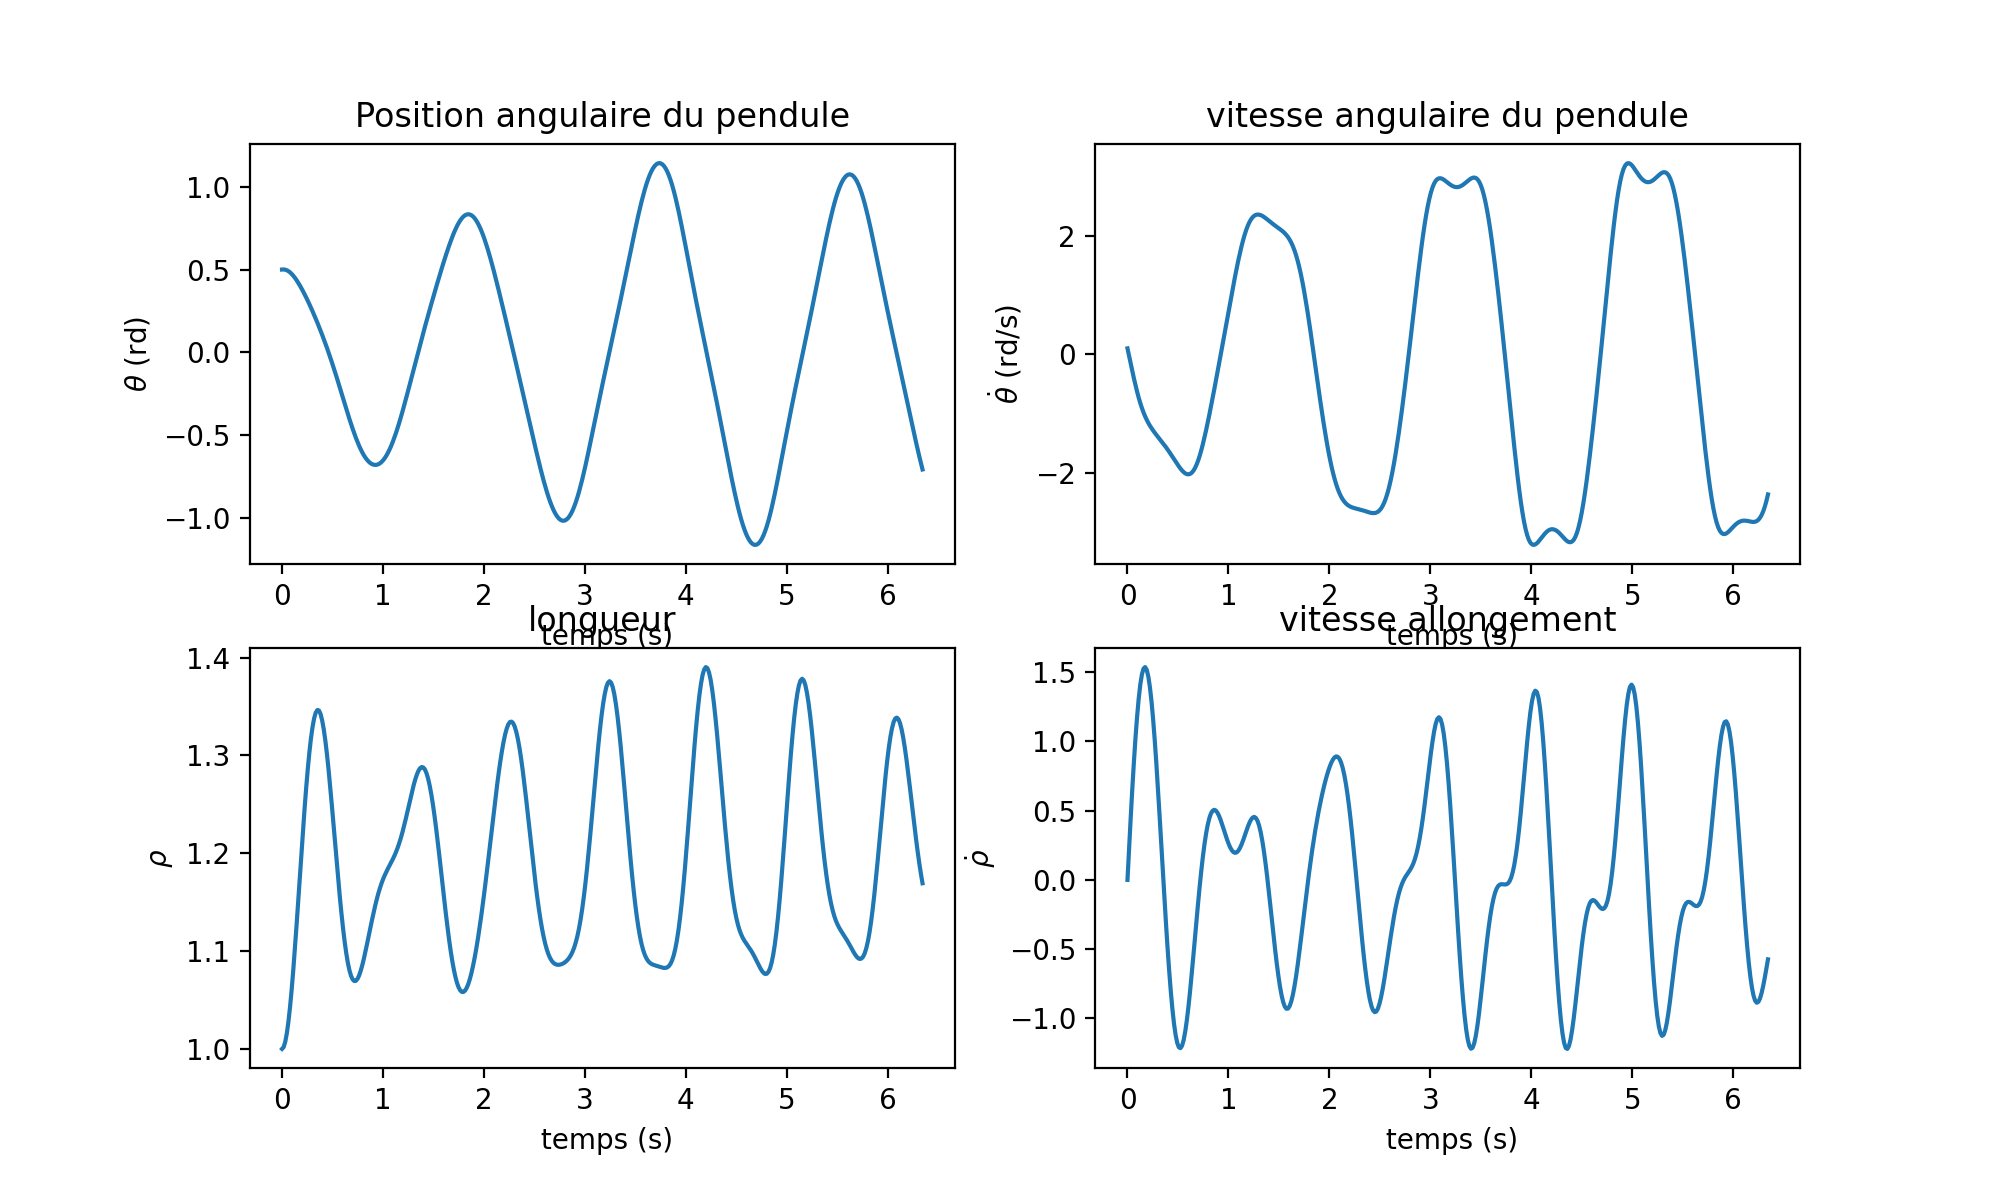

In [65]:
fig = plt.figure(figsize=(10, 6));

ax = fig.add_subplot(2,2,1);
ax.plot(sol.t,sol.y[0]);
ax.set_xlabel(' temps (s)')
ax.set_ylabel(r'$ \theta $ (rd)')
ax.set_title('Position angulaire du pendule')

bx = fig.add_subplot(2,2,2);
bx.set_xlabel(' temps (s)')
bx.set_ylabel(r'$ \dot\theta $ (rd/s)')
bx.set_title('vitesse angulaire du pendule')
bx.plot(sol.t,sol.y[1]);

cx = fig.add_subplot(2,2,3);
cx.set_xlabel(' temps (s)')
cx.set_ylabel(r'$ \rho$')
cx.set_title('longueur')
cx.plot(sol.t,sol.y[2]);

dx = fig.add_subplot(2,2,4);
dx.set_xlabel(' temps (s)')
dx.set_ylabel(r'$ \dot\rho $')
dx.set_title('vitesse allongement')
dx.plot(sol.t,sol.y[3]);

<IPython.core.display.Javascript object>


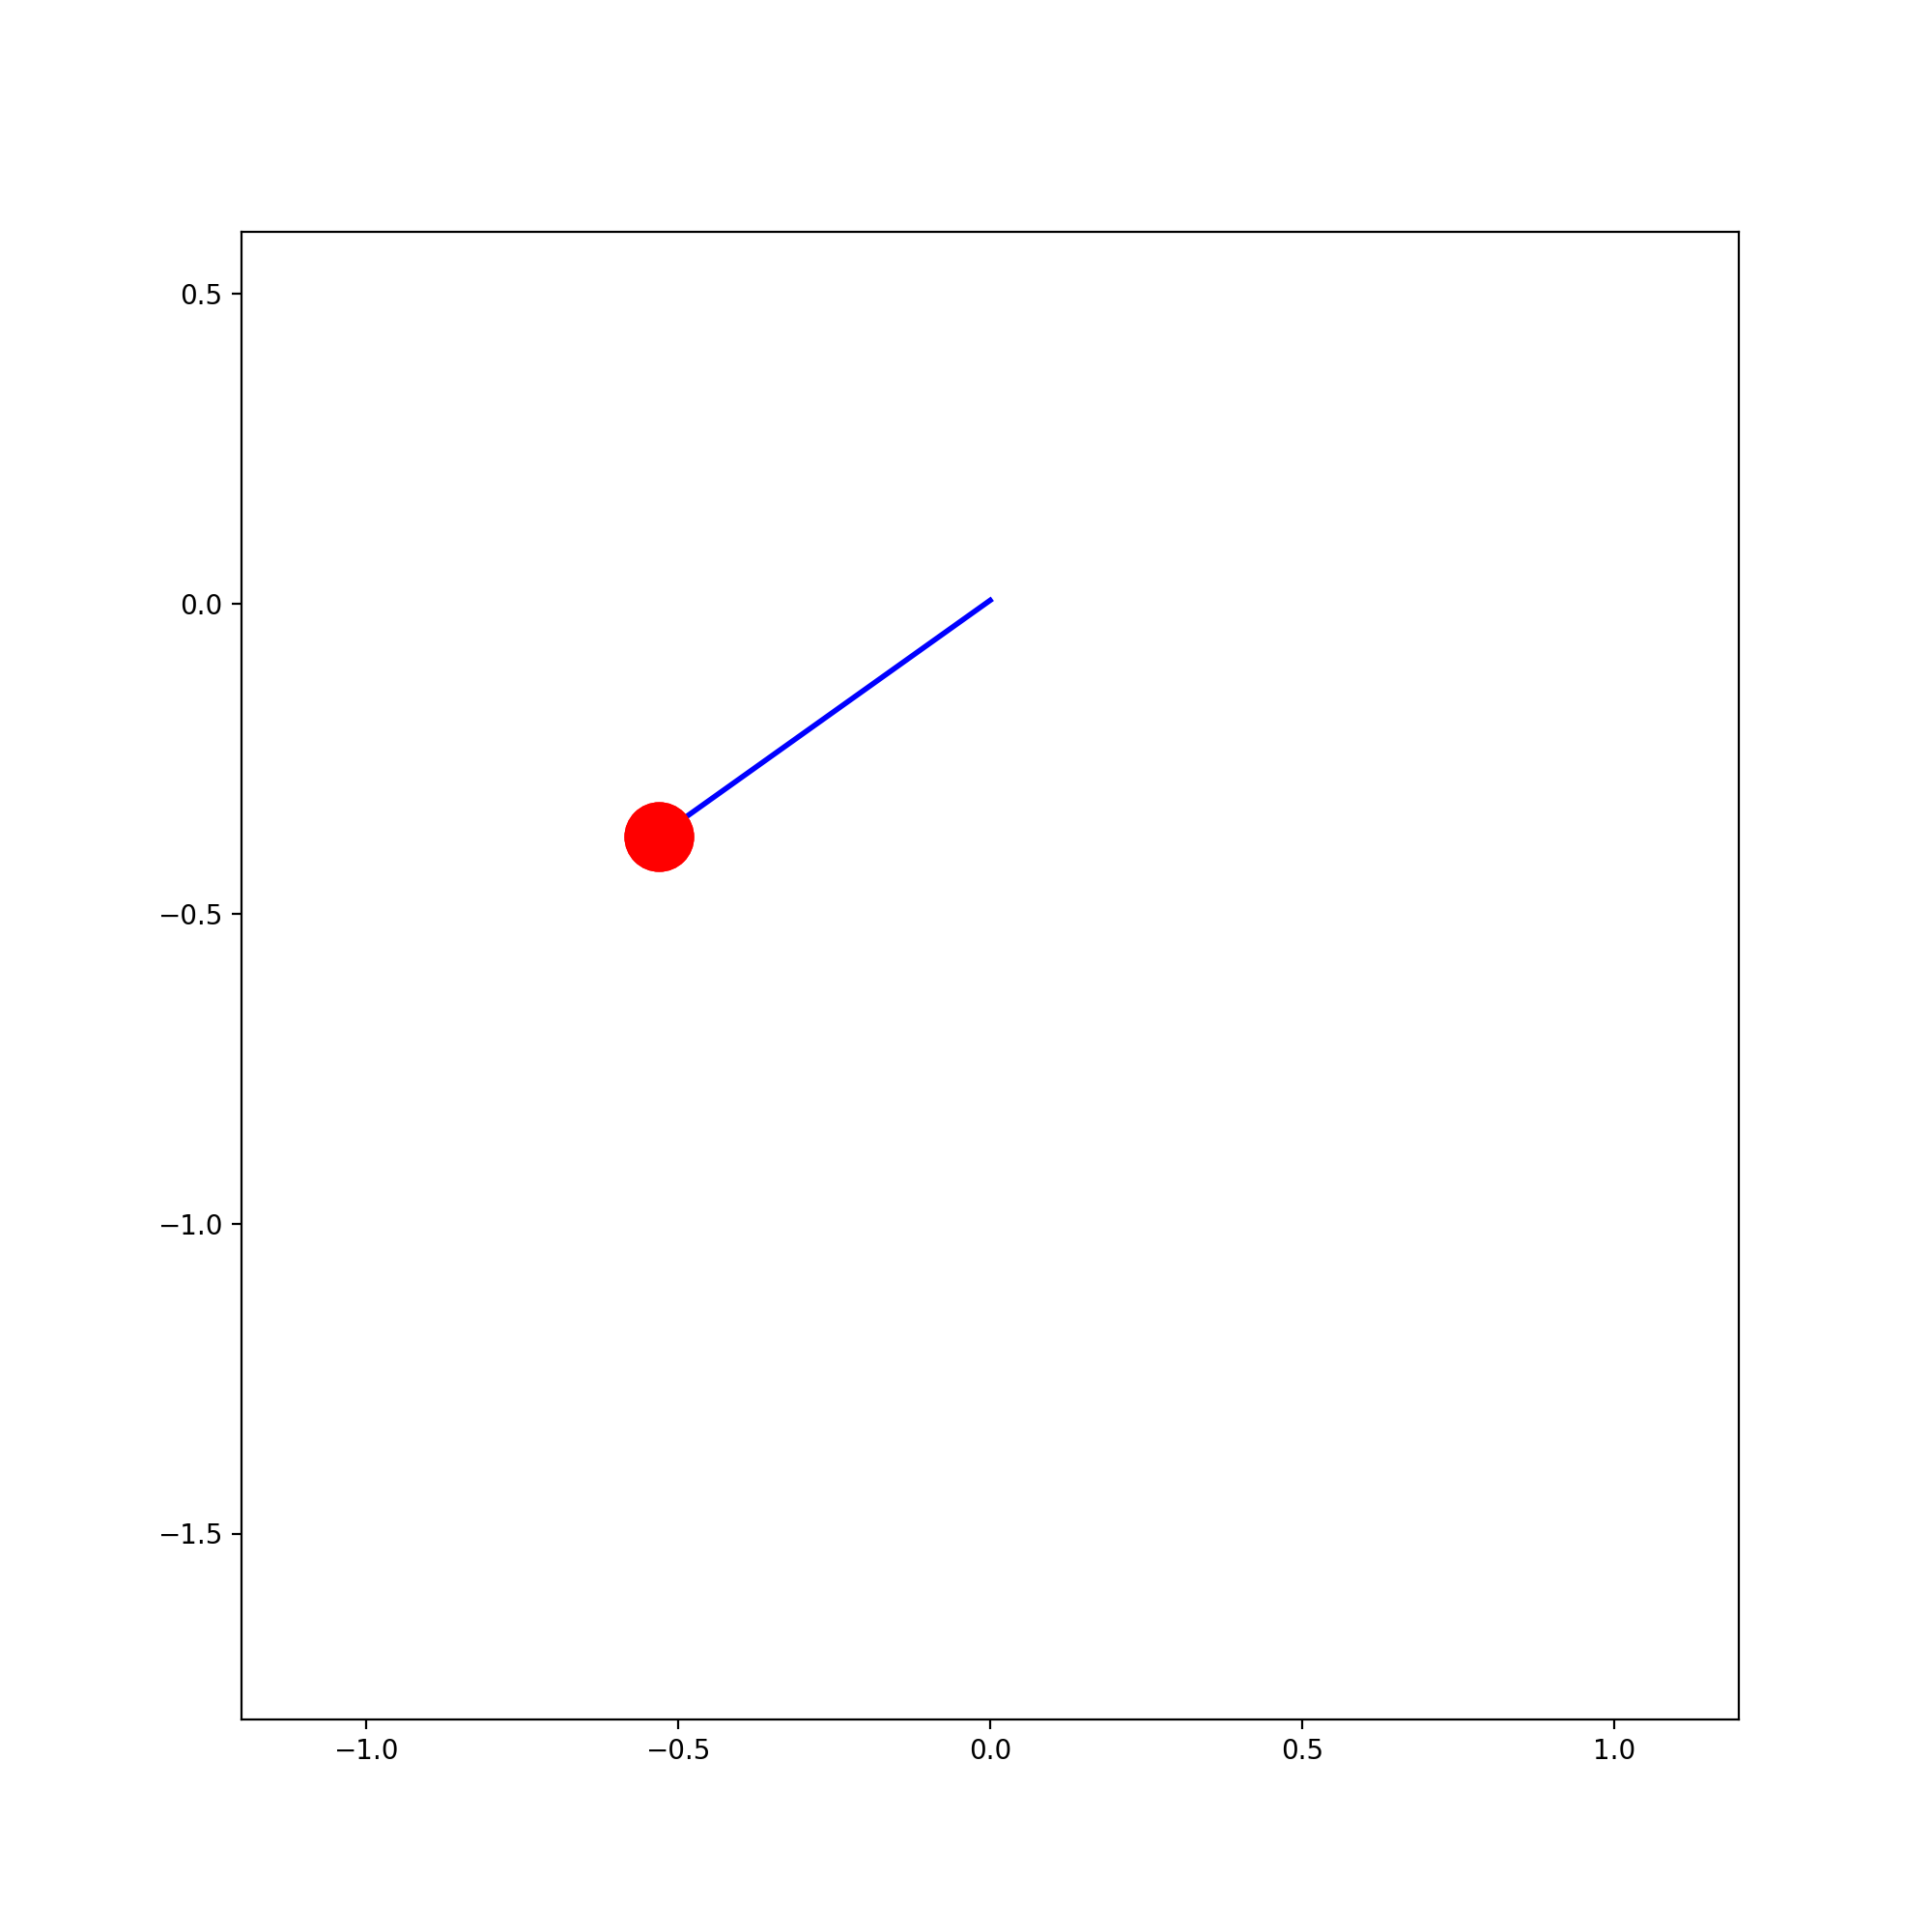

In [66]:
pos_x = l0*sol.y[2]*np.sin(sol.y[0]); pos_z=l0*sol.y[2]*np.cos(sol.y[0]) + a*np.sin(omega*sol.t)
#

#
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(autoscale_on=False, xlim=(-2*l0,2*l0), ylim = (-3*l0,l0))

# creation des éléments à animer : deux lignes, dont une à laquelle nous
# imposerons une longueur nulle à défaut d'avoir trouvé comment appliquer
# le méthode .set_data à un scatter... 
line, = ax.plot([],[],'b-',lw=2)
masse, = ax.plot([],[],'ro',ms=25) 


# fonction pour l'animation 
def anim_pendule(i):
    x_line = [0, pos_x[i]]
    y_line = [-a*np.sin(omega*sol.t[i]), -pos_z[i]]
    x_masse = [pos_x[i], pos_x[i]]
    y_masse = [-pos_z[i], -pos_z[i]]
    line.set_data(x_line,y_line)
    masse.set_data(x_masse,y_masse)
    return line, masse
#
ninc=(len(pos_x))
#
anim = animation.FuncAnimation(
    fig, anim_pendule, frames=ninc, interval=20, blit=True)
plt.show()

